# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Post-Calibration
With access to higher-grade instruments, we start to look at the possibility of post-calibrating the sensors to get more-reliable results.

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report
from src.calibration import run_calibration

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import
In the following cells, we grab the relevant data for the calibration events:
1. Background 2
 - **Start**: datetime(2020,12,28,11,12,0)
 - **End**: datetime(2020,12,28,12,12,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 40, 44, 46, 48]
2. Candle 1
 - datetime(2020,12,30,10,20,0)
 - datetime(2020,12,30,12,25,0)

In [92]:
c = run_calibration.Calibration(datetime(2020,12,28,11,12,0),datetime(2020,12,28,12,10,0),"../data/")

## Beacons
We have to grab the raw data from the beacons during the various calibration events. We can borrow from the ```porcess_beacon.py``` from the ```make_dataset.py``` source file.

In [93]:
beacon = c.get_beacon_data([1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 40, 44, 46, 48])

## Reference Instruments
All data are saved as dataframes in a dictionary indexed by the pollutant type

In [94]:
ref = {}
for pollutant, f in zip(["pm_count","pm_number","pm_concentration","no","no2","co2"],[c.get_pm_ref,c.get_pm_ref,c.get_pm_ref,c.get_no_ref,c.get_no2_ref,c.get_co2_ref]):
    ref[pollutant] = f(f"{pollutant}_{c.date}.csv")

# Base Visualization
Visually comparing measurements

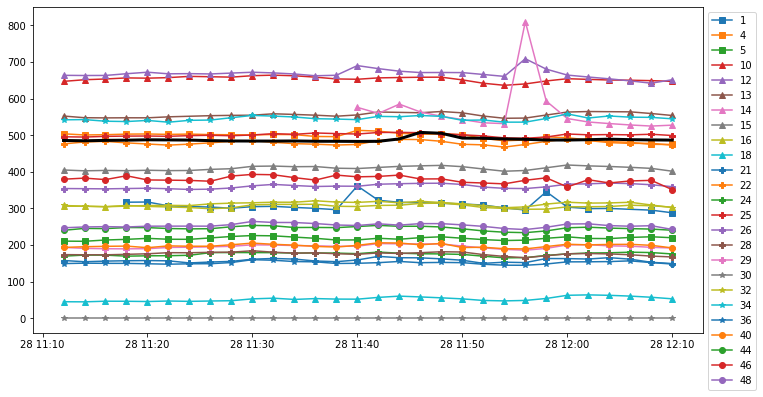

In [95]:
c.plot_time_series(ref["co2"],beacon[["CO2","Beacon"]])

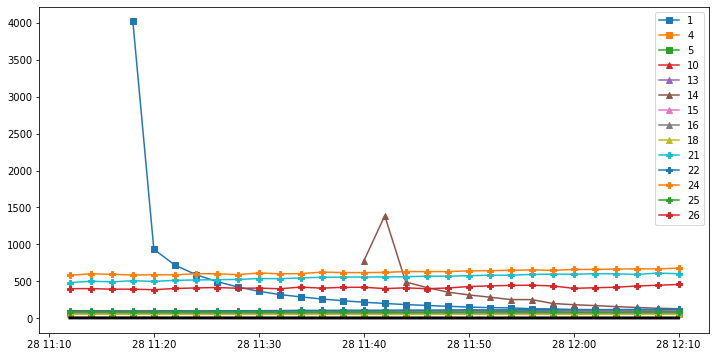

In [96]:
c.plot_time_series(ref["no2"],beacon[["NO2","Beacon"]])

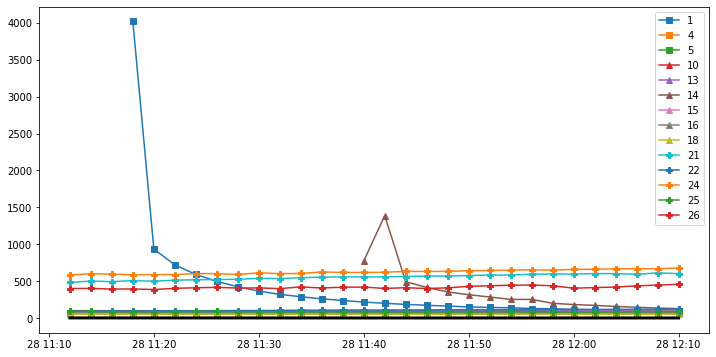

In [97]:
c.plot_time_series(ref["no"],beacon[["NO2","Beacon"]])

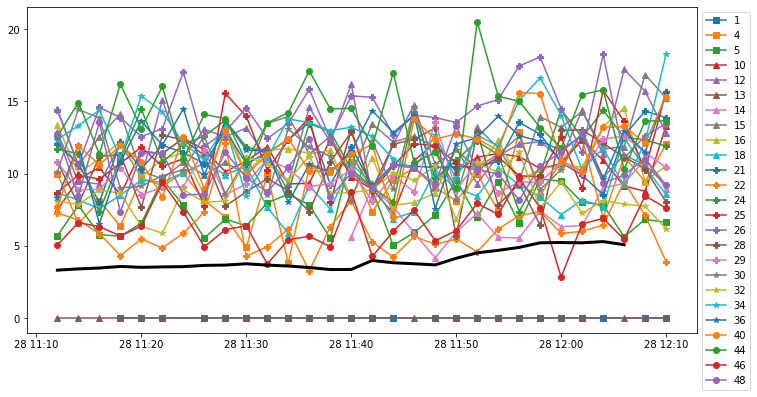

In [98]:
c.plot_time_series(ref["pm_concentration"][["PM_2p5"]],beacon[["PM_C_2p5","Beacon"]])

# Analysis

In [99]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Linear Regression
We can run linear regression for each of the beacons to determine how we can best correct our data.

In [116]:
def regression(ref_data, beacon_data, test_size=1):
    """
    Runs a regression model
    
    Inputs:
    - ref_data:
    - beacon_data: 
    - test_size: float specifying the proportion of data to use for the training set
    
    """

    if len(ref_data) == len(beacon_data):
        index = int(test_size*len(ref_data))
    else:
        raise ValueError("Reference and Beacon data must be the same length.")
    # splitting beacon data
    if test_size == 1:
        y_train = beacon_data.iloc[:,0].values
        y_test = beacon_data.iloc[:,0].values
    else:
        y_train = beacon_data.iloc[:,0].values[:index]
        y_test = beacon_data.iloc[:,0].values[index:]

    # splitting ref data
    if test_size == 1:
        x_train = ref_data.iloc[:,0].values
        x_test = ref_data.iloc[:,0].values
    else:
        x_train = ref_data.iloc[:,0].values[:index]
        x_test = ref_data.iloc[:,0].values[index:]

    # linear regression model
    regr = linear_model.LinearRegression()
    regr.fit(x_train.reshape(-1, 1), y_train)

    # The coefficients
    print('Coefficients: \n', regr.coef_)

    # Make predictions using the testing set
    y_pred = regr.predict(x_test.reshape(-1, 1))

    # plotting
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x_train,y_train,color="orange",alpha=0.7,label="Training")
    ax.scatter(x_test,y_test,color='seagreen',label="Test")
    ax.plot(x_test,y_pred,color='cornflowerblue',linewidth=3,label="Prediction")
    ax.legend(bbox_to_anchor=(1,1),frameon=False)

    plt_min = 0.95*min(min(x_train),min(y_train))
    plt_max = 1.05*max(max(x_train),max(y_train))
    ax.set_xlim([plt_min,plt_max])
    ax.set_ylim([plt_min,plt_max])

    plt.show()
    plt.close()

Coefficients: 
 [-0.03937864]


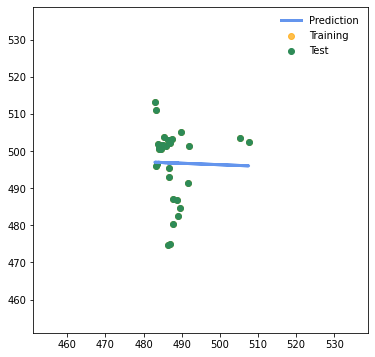

In [117]:
df = beacon[beacon["Beacon"] == 4]
df_ref = ref["co2"]
regression(df_ref,df[["CO2"]])